In [1]:
import json_lines
import re
import seaborn as sns
import matplotlib.pyplot as plt
import os
from collections import Counter
import string
import math
import pickle

import numpy as np
import pandas as pd

#Question 1

In [9]:
#109 wiki pages
#5416537 documents in wiki pages 
#type(documents) == list
#type(documents[0]) == dict
def load_wiki_docs():
    documents = []
    iterator_doc = 1
    iterator_text = 1
    for doc in os.listdir("./wiki-pages"):
        print("loading ",iterator_doc, "page/109 pages", end='\r')
        with json_lines.open('./wiki-pages/' + doc) as f:
            for item in f:
                documents.append(item)
                iterator_text +=1
        iterator_doc += 1
    print("successfully loaded wiki pages!")
    return documents

def calculate_term_frequency_wiki_docs(documents):
    term_frequency_wiki_documents = Counter()
    iterator_doc = 0
    for document in documents:
        term_frequency_wiki_documents.update(document['text'].lower()
            .translate(str.maketrans('','',string.punctuation)).split()) 
        if iterator_doc % 10000 == 0:
            print("calculate total word counts: "
                  ,"%.2f" % (iterator_doc/5416537 * 100)
                  , "% completed", end='\r')
        iterator_doc += 1
    print("calculation of word counts in wiki documents completed!")
    return term_frequency_wiki_documents

def verify_zip_law(term_frequency_wiki_documents):
    word_counts_zip_law = list(term_frequency_wiki_documents.values())
    word_counts_zip_law.sort(reverse = True)
    return word_counts_zip_law

Question2

In [10]:
def get_word_list(term_frequency_wiki_documents):
    return list(dict(term_frequency_wiki_documents).keys())

def calculate_doc_frequency(documents, word_list):
    df_dict = dict.fromkeys(word_list,0)
    iterator_doc = 0
    for document in documents:
        words_in_doc = document['text'].lower().translate(str.maketrans('','',string.punctuation)).split()
        if iterator_doc % 10000 == 0:
            print("calculate document frequency: "
                  , "%.2f" % (iterator_doc/5416537 * 100)
                  ,"% completed", end='\r')
        iterator_doc += 1
        for word in set(words_in_doc):
            df_dict[word] += 1
    print("calculation of document frequency in wiki documents completed!")    
    return df_dict

def calculate_term_frequency(text_string, word_list):
    tf_dict = dict.fromkeys(word_list,0)
    words_in_text = text_string.lower().translate(str.maketrans('','',string.punctuation)).split()
    for word in words_in_text:
        tf_dict[word] += 1
    return tf_dict

def load_training_datasets():
    claim_id_list = [75397, 150448, 214861, 156709, 129629, 33078, 6744, 226034, 40190, 76253]
    train_raw_dataset = []
    claims_for_q2 = []
    with open('./train.jsonl') as f:
        print("loading training dataset")
        for train in json_lines.reader(f):
            train_raw_dataset.append(train)
            if train['id'] in claim_id_list:
                claims_for_q2.append(train)
    return train_raw_dataset, claims_for_q2

def calculate_tf_wiki_documents(documents):
    tf_wiki_docs = []
    iterator_doc = 0
    for document in documents:
        tf_wiki_doc = dict()
        tf_wiki_doc['id'] = document['id']
        term_frequency_wiki_document = Counter()
        term_frequency_wiki_document.update(document['text'].lower()
            .translate(str.maketrans('','',string.punctuation)).split()) 
        tf_wiki_doc['tf'] = dict(term_frequency_wiki_document)
        tf_wiki_docs.append(tf_wiki_doc)
        if iterator_doc % 10000 == 0:
            print("calculate term frequency for wiki docs: "
                  , "%.2f" % (iterator_doc/5416537 * 100)
                  ,"% completed", end='\r')
        iterator_doc += 1
    print("calculation of term frequency in wiki documents completed!")    
    return tf_wiki_docs

def calculate_tf_claims(claims):
    tf_claims = []
    iterator_doc = 0
    for claim in claims:
        tf_claim = dict()
        tf_claim['id'] = claim['id']
        term_frequency_claim = Counter()
        term_frequency_claim.update(claim['claim'].lower()
            .translate(str.maketrans('','',string.punctuation)).split())
        tf_claim['tf'] = dict(term_frequency_claim)
        tf_claims.append(tf_claim)
        print("calculate term frequency for claims: "
                  , "%.2f" % (iterator_doc)
                  ," completed", end='\r')
        iterator_doc += 1
    print("calculation of term frequency in claims completed!")    
    return tf_claims

def calculate_tfidf_wiki_docs(tf_wiki_docs,df_dict):
    tfidf_wiki_docs = []
    iterator_doc = 0
    for tf_wiki_doc in tf_wiki_docs:
        tfidf_wiki_doc = dict()
        tfidf_wiki_doc['id'] = tf_wiki_doc['id']
        tfidf_wiki_doc['tf'] = dict()
        for word in tf_wiki_doc['tf'].keys():
            tfidf_wiki_doc['tf'][word] = tf_wiki_doc['tf'][word]/df_dict[word]
        tfidf_wiki_docs.append(tfidf_wiki_doc)
        if iterator_doc % 10000 == 0:
            print("calculate tf-idf for wiki docs: "
                  , "%.2f" % (iterator_doc/5416537 * 100)
                  ,"% completed", end='\r')
        iterator_doc += 1
    print("calculation of tfidf in wiki documents completed!")
    return tfidf_wiki_docs

def calculate_tfidf_claims(tf_train_claims,df_dict):
    tfidf_train_claims = []
    iterator_doc = 0
    for tf_train_claim in tf_train_claims:
        tfidf_train_claim = dict()
        tfidf_train_claim['id'] = tf_train_claim['id']
        tfidf_train_claim['tf'] = dict()
        for word in tf_train_claim['tf'].keys():
            tfidf_train_claim['tf'][word] = tf_train_claim['tf'][word]/df_dict[word]
        tfidf_train_claims.append(tfidf_train_claim)
        
        print("calculate tf-idf for training claims: "
                  , "%.2f" % (iterator_doc)
                  ," completed", end='\r')
        iterator_doc += 1
    print("calculation of tfidf in claims completed!")
    return tfidf_train_claims

def calculate_cosine_similarity(dict1,dict2):
    numerator = 0
    for word_in_both in dict1.keys() & dict2.keys():
        numerator += dict1[word_in_both] * dict2[word_in_both]
    dict1_vector = np.array(list(dict1.values()))
    dict2_vector =  np.array(list(dict2.values()))
    denominator = np.linalg.norm(dict1_vector) * np.linalg.norm(dict2_vector)
    return numerator / denominator

def calculate_top5(tfidf_train_claims, tfidf_wiki_docs):
    top5_for_claims = dict()
    claim_iterator = 0
    for tfidf_train_claim in tfidf_train_claims:
        print("calculating claim: ",claim_iterator)
        claim_iterator += 1
        
        top5_for_claim = dict()
        for tfidf_wiki_doc in tfidf_wiki_docs[0:5]:
            iterator_doc = 0
            top5_for_claim[tfidf_wiki_doc['id']] = calculate_cosine_similarity(tfidf_train_claim['tf'],tfidf_wiki_doc['tf'])
        min_value_key = min(top5_for_claim, key=top5_for_claim.get)
        min_value = top5_for_claim[min_value_key]
        for tfidf_wiki_doc in tfidf_wiki_docs[5:]:
            cos_sim = calculate_cosine_similarity(tfidf_train_claim['tf'],tfidf_wiki_doc['tf'])
            if cos_sim > min_value:
                del top5_for_claim[min_value_key]
                top5_for_claim[tfidf_wiki_doc['id']] = cos_sim
                min_value_key = min(top5_for_claim, key=top5_for_claim.get)
                min_value = top5_for_claim[min_value_key]
            if iterator_doc % 10000 == 0:
                print("calculate cosine similarity between wiki docs and ", claim_iterator, "th claim"
                  , "%.2f" % (iterator_doc/5416537 * 100)
                  ,"% completed", end='\r')
            iterator_doc += 1
        top5_for_claims[tfidf_train_claim['id']] = top5_for_claim
    return top5_for_claims



successfully loaded wiki pages!
calculation of word counts in wiki documents completed!


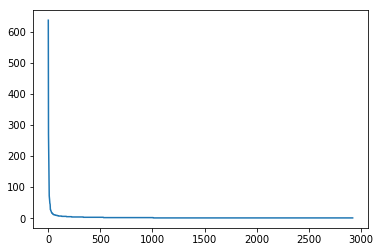

In [4]:
#main() for q1
documents = load_wiki_docs()   
term_frequency_wiki_documents = calculate_term_frequency_wiki_docs(documents)    
word_counts_zip_law = verify_zip_law(term_frequency_wiki_documents)
plt.plot(word_counts_zip_law)

In [41]:
word_list = get_word_list(term_frequency_wiki_documents)
df_dict = calculate_doc_frequency(documents,word_list)
train_raw_dataset, claims_for_q2 = load_training_datasets()
tf_train_claims = calculate_tf_claims(claims_for_q2, word_list)
tf_wiki_docs = calculate_tf_wiki_documents(documents, word_list)
del documents
del term_frequency_wiki_documents
del word_counts_zip_law
del claims_for_q2
del train_raw_dataset
del word_list
gc.collect()
tfidf_train_claims = calculate_tfidf_claims(tf_train_claims,df_dict)
tfidf_wiki_docs = calculate_tfidf_wiki_docs(tf_wiki_docs,df_dict)
del tf_train_claims
del tf_wiki_docs
gc.collect()
top5_docs_for_claims = calculate_top5(tfidf_train_claims, tfidf_wiki_docs)

calculation of document frequency in wiki documents completed!
loading training dataset


#Question3

In [72]:
def laplace_smoothing(word, document_unique_word_count, document_word_count, document, document_words):
    if word not in document_words:
        document[word] = 0
    return (document[word] + 1)/(document_unique_word_count + document_word_count)


def calculate_query_likelihood(query, document, smoothing_type):
    query_likelihood = 1
    if smoothing_type == "laplace":
        document_words = document.keys()
        document_unique_word_count = len(document_words)
        document_word_count = sum(document.values())
        for word in query:
            query_likelihood *= laplace_smoothing(word, document_unique_word_count, document_word_count
                                                  , document, document_words)
#     elif smoothing_type == "jm":
#         break
#     elif smoothing_type == "dirichlet":
#         break
    return query_likelihood

def calculate_top5_prob(claims_for_q2, tf_wiki_docs, smoothing_type):  
    top5_for_claims_prob = dict()
    claim_iterator = 0
    for claim in claims_for_q2:
        claim_iterator += 1
        query = claim['claim'].lower().translate(str.maketrans('','',string.punctuation)).split()
        top5_for_claim_prob = dict()
        for tf_wiki_doc in tf_wiki_docs[0:5]:
            iterator_doc = 0
            document = tf_wiki_doc['tf']
            top5_for_claim_prob[tf_wiki_doc['id']] = calculate_query_likelihood(query, document, smoothing_type)
        min_value_key = min(top5_for_claim_prob, key=top5_for_claim_prob.get)
        min_value = top5_for_claim_prob[min_value_key]
        max_vk = max(top5_for_claim_prob, key=top5_for_claim_prob.get)
        max_v = top5_for_claim_prob[max_vk]
        print("startmax", claim['id'], max_v)
        print("startmin", claim['id'], min_value)
        for tf_wiki_doc in tf_wiki_docs[5:]:
            document = tf_wiki_doc['tf']
            query_likelihood = calculate_query_likelihood(query, document, smoothing_type)
            if query_likelihood > min_value:
                del top5_for_claim_prob[min_value_key]
                top5_for_claim_prob[tf_wiki_doc['id']] = query_likelihood
                min_value_key = min(top5_for_claim_prob, key=top5_for_claim_prob.get)
                min_value = top5_for_claim_prob[min_value_key]
                max_vk = max(top5_for_claim_prob, key=top5_for_claim_prob.get)
                max_v = top5_for_claim_prob[max_vk]
            if iterator_doc % 10000 == 0:
                print("calculate query likelihood between wiki docs and ", claim_iterator, "th claim"
                  , "%.2f" % (iterator_doc/5416537 * 100)
                  ,"% completed", end='\r')
            iterator_doc += 1
        top5_for_claims_prob[claim['id']] = top5_for_claim_prob
    return top5_for_claims_prob

In [20]:
documents = load_wiki_docs()
train_raw_dataset, claims_for_q2 = load_training_datasets()
tf_wiki_docs = calculate_tf_wiki_documents(documents)
top5_docs_for_claims_prob = calculate_top5_prob(claims_for_q2, tf_wiki_docs, "laplace")
# to do: other 2 smoothing 

successfully loaded wiki pages!
calculation of word counts in wiki documents completed!
loading training dataset
calculation of term frequency in wiki documents completed!


NameError: name 'calculate_top5_prob' is not defined